In [1]:
!pip install tslearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 13.6 MB/s eta 0:00:00


In [2]:
from warnings import filterwarnings

filterwarnings('ignore')

In [3]:
import pandas as pd

train_df = pd.read_parquet('/kaggle/input/vk-qual-data/train.parquet')
test_df = pd.read_parquet('/kaggle/input/vk-qual-data/test.parquet')

In [4]:
train_df.head()

,id,dates,values,label
0,19114,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[-1.86, 0.79, 1.4, 0.15, 0.0, -1.24, -1.46, 3....",0.0
1,22769,"[2016-05-01, 2016-06-01, 2016-07-01, 2016-08-0...","[-1.04, -3.48, 0.05, -0.13, -0.01, 0.03, 0.27,...",1.0
2,76935,"[2017-03-01, 2017-04-01, 2017-05-01, 2017-06-0...","[0.28, 0.63, 0.06, 0.96, -1.4, -0.3, 1.62, 1.1...",0.0
3,66297,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[-0.33, 0.58, 1.1, -0.56, -0.95, -0.61, -0.7, ...",0.0
4,2191,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[1.31, 0.5, -0.54, 0.95, 0.65, 0.83, -1.55, -0...",0.0


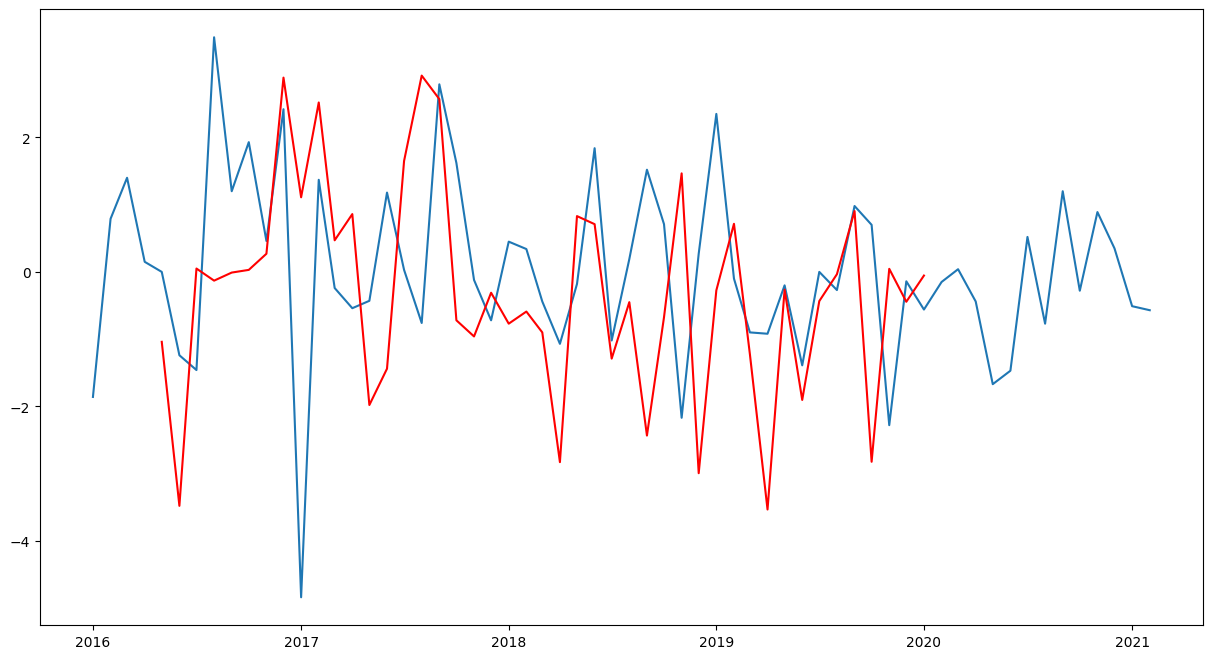

In [5]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(15, 8))
ax.plot(train_df['dates'][0], train_df['values'][0])
ax.plot(train_df['dates'][1], train_df['values'][1], color='red')
plt.show()

In [6]:
train_df['label'].unique()

array([0., 1.])

<Axes: >

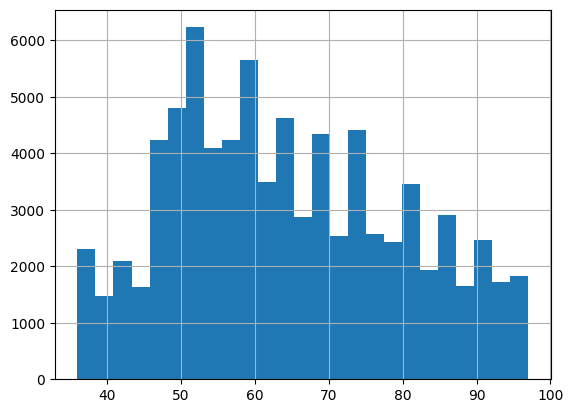

In [7]:
train_df['values'].str.len().hist(bins=25)

<Axes: >

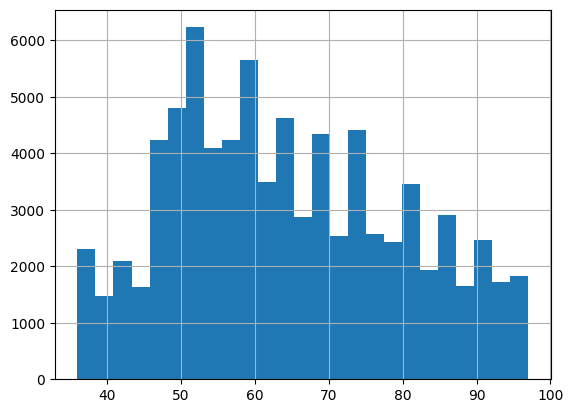

In [8]:
train_df['dates'].str.len().hist(bins=25)

In [9]:
MIN = train_df['values'].str.len().min()
MIN

36

In [10]:
import numpy as np

idx = []
for i, value_lst in enumerate(train_df['values']):
    if np.isnan(value_lst).any() == True:
        idx.append(i)

train_df = train_df.drop(idx)
train_df = train_df.reset_index(drop=True)

In [11]:
from tslearn.utils import to_time_series_dataset

X = to_time_series_dataset(train_df['values'])

In [12]:
from tslearn.preprocessing import TimeSeriesResampler

resampled_X = TimeSeriesResampler(sz=MIN).fit_transform(X)

In [13]:
import torch
import torch.nn as nn

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [14]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=1000, output_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        
        self.lstm = nn.LSTM(input_size, hidden_size)
        
        self.linear = nn.Linear(hidden_size, output_size)
        
        self.hidden = (torch.zeros(1, 1, self.hidden_size), torch.zeros(1, 1, self.hidden_size))

    def forward(self, seq):
        lstm_out, self.hidden = self.lstm(seq.view(len(seq), 1, -1), self.hidden)
        pred = self.linear(lstm_out.view(len(seq), -1))
        return pred[-1]

In [15]:
X = resampled_X.squeeze()
# X = X[:500]

In [16]:
train_data = torch.tensor(X, dtype=torch.float32)
target = torch.tensor(train_df['label'].values, dtype=torch.float32)

In [17]:
model = LSTM()
model.to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
model.train()

LSTM(
  (lstm): LSTM(1, 1000)
  (linear): Linear(in_features=1000, out_features=1, bias=True)
)

In [18]:
from tqdm import trange

epochs = 10
y_preds = []
for epoch in trange(epochs):
    for seq, t in zip(train_data, target):
        seq = seq.to(device)
        t = t.to(device)
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1, 1, model.hidden_size).to(device), torch.zeros(1, 1, model.hidden_size).to(device))
        y_pred = model(seq)
        loss = criterion(y_pred, t)
        loss.backward()
        optimizer.step()
        if epoch + 1 == epochs:
            y_preds.append(y_pred.cpu().detach())
    print(f'Epoch: {epoch+1:2} Loss: {loss.item():.8f}')

 10%|█         | 1/10 [09:53<1:28:59, 593.32s/it]

Epoch:  1 Loss: 0.23267256


 20%|██        | 2/10 [19:42<1:18:47, 590.99s/it]

Epoch:  2 Loss: 0.14323612


 30%|███       | 3/10 [29:38<1:09:12, 593.28s/it]

Epoch:  3 Loss: 0.12830387


 40%|████      | 4/10 [39:29<59:14, 592.49s/it]  

Epoch:  4 Loss: 0.05043928


 50%|█████     | 5/10 [49:12<49:04, 588.92s/it]

Epoch:  5 Loss: 0.03894572


 60%|██████    | 6/10 [58:57<39:10, 587.73s/it]

Epoch:  6 Loss: 0.02248549


 70%|███████   | 7/10 [1:08:44<29:21, 587.21s/it]

Epoch:  7 Loss: 0.02416231


 80%|████████  | 8/10 [1:18:35<19:36, 588.49s/it]

Epoch:  8 Loss: 0.01708956


 90%|█████████ | 9/10 [1:28:28<09:49, 589.92s/it]

Epoch:  9 Loss: 0.01420031


100%|██████████| 10/10 [1:38:23<00:00, 590.33s/it]

Epoch: 10 Loss: 0.01273043


In [19]:
torch.save(model.state_dict(), 'model.pth')

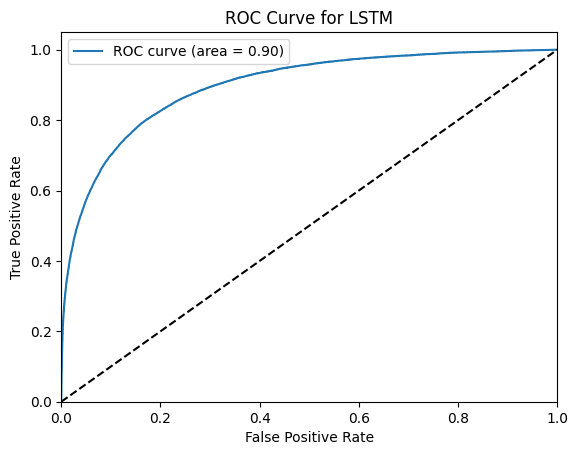

In [20]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(target.cpu(), y_preds) 
roc_auc = auc(fpr, tpr)

plt.figure()  
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for LSTM')
plt.legend()
plt.show()
